# Red Neuronal Convolutiva. Clasificación de flores

En este proyecto construimos una red neuronal siguiendo una arquitectura convolutiva, para poder discernir entre 5 clases distintas de flores (rosas, margaritas, dientes de león, tulipanes y girasoles).

El *dataset* utilizado pertenece a Alexander Mamaev, descargado de [aquí](https://www.kaggle.com/alxmamaev/flowers-recognition)  y con uso libre según el mismo autor.

Como se ha comentado, el uso de una arquitectura de red convolutiva permite analizar las imágenes gracias a 

## Conexión con Google Drive para acceso al DataSet

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Preparación del dataset

Importamos todas las clases necesarias. Se utilizará la API Keras junto con TensorFlow como backend.

Hemos establecido un diccionario con los hiperparámetros que afinar una vez modelada la red. Se podrá en el futuro hacer uso de una librería como [Talos](https://github.com/autonomio/talos) para optimizar los mismos, pero hoy en día (18.05.19) no es capaz de trabajar con la función **fit_generator** de Keras para ejecutar el modelo.

Gracias a la clase **ImageDataGenerator** de Keras, podemos aumentar nuestro dataset de entrenamiento a base de aplicar funciones como rotación o volteo. Al final de las transformaciones se aplica un factor de división (255) para hacer que los valores RGB de cada canal tengan un rango \[0 - 1]. En el caso de las imágenes de validación, sólo se le aplica ésto último.

In [16]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adadelta
from keras.activations import softmax
from keras.losses import categorical_crossentropy
import keras
#import talos

# Hyperparameters. Not all of them all strictly hp, but for ease of use are
# concentrated here.
hp = {
    'img_height':200,
    'img_length':200,
    'img_channels':3, # RGB Channels
    'activation':'relu', # Rectified Linear Unit
    'last_layer_nodes': 5, # Number of final categories
    'last_activation':'softmax', # One-hot encoding
    'optimizer': Adadelta(), # Improved Adagrad, it keeps learning no matters any update
    'loss': categorical_crossentropy,
    'batch_size': 32,
    'epochs': 10
}

# Data Sources
train_data_dir = '/content/drive/My Drive/colab-notebooks/datasets/FlowersDS/train'
validation_data_dir = '/content/drive/My Drive/colab-notebooks/datasets/FlowersDS/validation'


# DATA GENERATION -----------------------------------------

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=10,
    zoom_range=0.2,
    horizontal_flip=True, # Randomly flip inputs horizontally
    vertical_flip=False # or vertically. 
)

validation_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(hp['img_length'], hp['img_height']),
    batch_size=hp['batch_size'],
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(hp['img_length'], hp['img_height']),
    batch_size=hp['batch_size'],
    class_mode='categorical'
)

Found 3000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


## Definición del Modelo de Red Neuronal Convolutiva

Definimos un modelo secuencial formado por 4 capas **convolutivas** para abstraer todas las características importantes de cada imagen. 

Con el objetivo de disminuir la carga de cómputo, a cada una de las convolutivas le sigue una capa de **agrupación** (pooling), para disminuir los datos a la mitad (malla de 2x2).

Con el objetivo de evitar el sobreajuste (overfitting), se colocan también dos capas **dropout**, para "congelar" los pesos de neuronas aleatorias durante sólo el entrenamiento.

Por último, se aplica una capa para "aplanar" (**flatten**) el tensor tridimensional de salida de las capas convolutivas a un vector para poder ser procesada por dos capas fully-connected (**dense**), teniendo la última una función de activación *softmax* para obtener una salida con formato *one-hot* (vector de probabilidades unitarias). 

In [18]:
# MODEL DEFINITION -----------------------------------------

def flower_model(train_generator, validation_generator, hp):
  
  model = Sequential()
  
  model.add(Conv2D(filters = 32, 
                   kernel_size = (3, 3),
                   activation = hp['activation'],
                   input_shape = (hp['img_length'], hp['img_height'], hp['img_channels'])))
  model.add(MaxPooling2D(2))
  
  model.add(Conv2D(64, 3, activation = hp['activation']))
  model.add(MaxPooling2D(2))
  
  model.add(Conv2D(128, 3, activation = hp['activation']))
  model.add(MaxPooling2D(2))
  
  model.add(Conv2D(128, 3, activation = hp['activation']))
  model.add(MaxPooling2D(2))
  
  model.add(Dropout(0.25))
  
  model.add(Flatten())
  model.add(Dense(32, activation=hp['activation']))
  
  model.add(Dropout(0.5))
  
  model.add(Dense(hp['last_layer_nodes'], activation=hp['last_activation']))
  
  model.compile(loss=hp['loss'], 
                       optimizer=hp['optimizer'],
                       metrics=['accuracy'])
  return model

# Start Model

flower_model = flower_model(train_generator, validation_generator, hp)

flower_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 146, 146, 64)      18496     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 144, 144, 128)     73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 72, 72, 128)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 70, 70, 128)       147584    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 35, 35, 128)       0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 35, 35, 128)       0         
__________

## Ejecución del Modelo

In [19]:
# MODEL EXECUTION -----------------------------------------

def exec_model(model):
  return model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=hp['epochs'], 
      validation_data=validation_generator,
      validation_steps=200
  )
  
flower_result = exec_model(flower_model)

Epoch 1/10
100/100 [==============================] - 59s 591ms/step - loss: 1.5592 - acc: 0.2979 - val_loss: 1.3681 - val_acc: 0.4102
Epoch 2/10
100/100 [==============================] - 56s 561ms/step - loss: 1.4218 - acc: 0.3888 - val_loss: 1.1770 - val_acc: 0.5125
Epoch 3/10
100/100 [==============================] - 54s 539ms/step - loss: 1.3123 - acc: 0.4421 - val_loss: 1.1381 - val_acc: 0.5472
Epoch 4/10
100/100 [==============================] - 54s 537ms/step - loss: 1.2424 - acc: 0.4822 - val_loss: 1.0780 - val_acc: 0.5317
Epoch 5/10
100/100 [==============================] - 54s 543ms/step - loss: 1.1975 - acc: 0.5088 - val_loss: 1.2442 - val_acc: 0.5254
Epoch 6/10
100/100 [==============================] - 54s 536ms/step - loss: 1.1373 - acc: 0.5335 - val_loss: 1.1077 - val_acc: 0.6214
Epoch 7/10
100/100 [==============================] - 54s 538ms/step - loss: 1.1054 - acc: 0.5592 - val_loss: 0.9484 - val_acc: 0.6472
Epoch 8/10
100/100 [==============================] - 5

## Generación de Gráficos

 Tras obtener los resultados, construimos gracias a la librería [Matplotlib](https://matplotlib.org/index.html) y su módulo **pyplot** unas gráficas que nos permiten interpretar mejor los valores de precisión y pérdida en las fases de entrenamiento y validación.

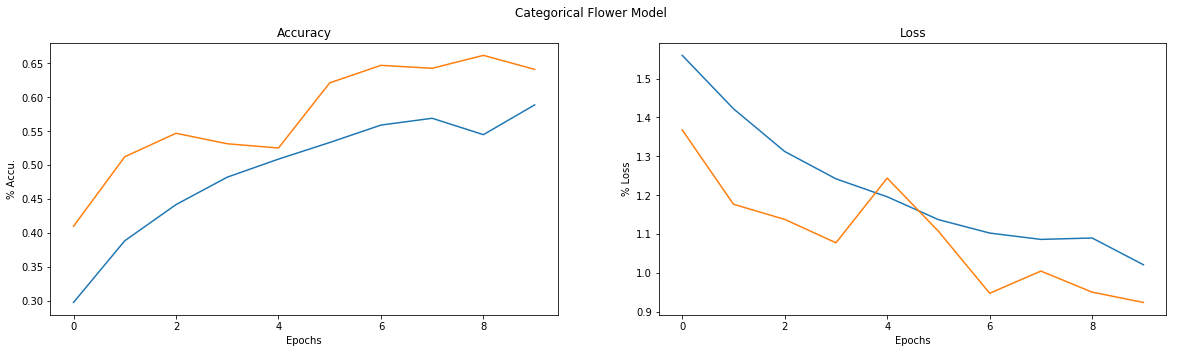

In [20]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharex=True)
fig.suptitle('Categorical Flower Model')

axs[0].set_title("Accuracy")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("% Accu.")
axs[0].plot(flower_result.history['acc'], label='acc')
axs[0].plot(flower_result.history['val_acc'], label='val_acc')


axs[1].set_title("Loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("% Loss")
axs[1].plot(flower_result.history['loss'], label='loss')
axs[1].plot(flower_result.history['val_loss'], label='val_loss')

plt.show()


## Conclusión

  Por ahora, la red no tiene unos índices de precisión aceptables. Existen varios motivos, siendo el más importante la propia estructura de la red, que no es capaz de discernir bien cuáles son las características más relevantes de cada imagen. También influye el propio conjunto de datos, que no siempre refleja una flor sino una escena con varias de ellas o en estados poco distinguibles.
  
  En otras ejecuciones más largas (con mayor número de capas y parámetros), se han obtenido valores de entre el 70-75% de precisión en el conjunto de validación, aunque sufriendo graves problemas de overfitting. Se diagnosticó al observar una precisión en el entrenamiento del 80-85%, que se traduce en que el modelo se comporta bien con unos datos, pero no es capaz de generalizar correctamente.
  
  Se seguirá mejorando el modelo a base, sobretodo, ¡del aprendizaje del propio autor!
  
---

